In [13]:
import numpy as np
from scipy.fft import fft, rfft, fftfreq, fftshift
from scipy.signal import correlate, welch
from scipy.signal.windows import hamming, hann
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('./nikhils_plot_style.mplstyle')

# Simulated data

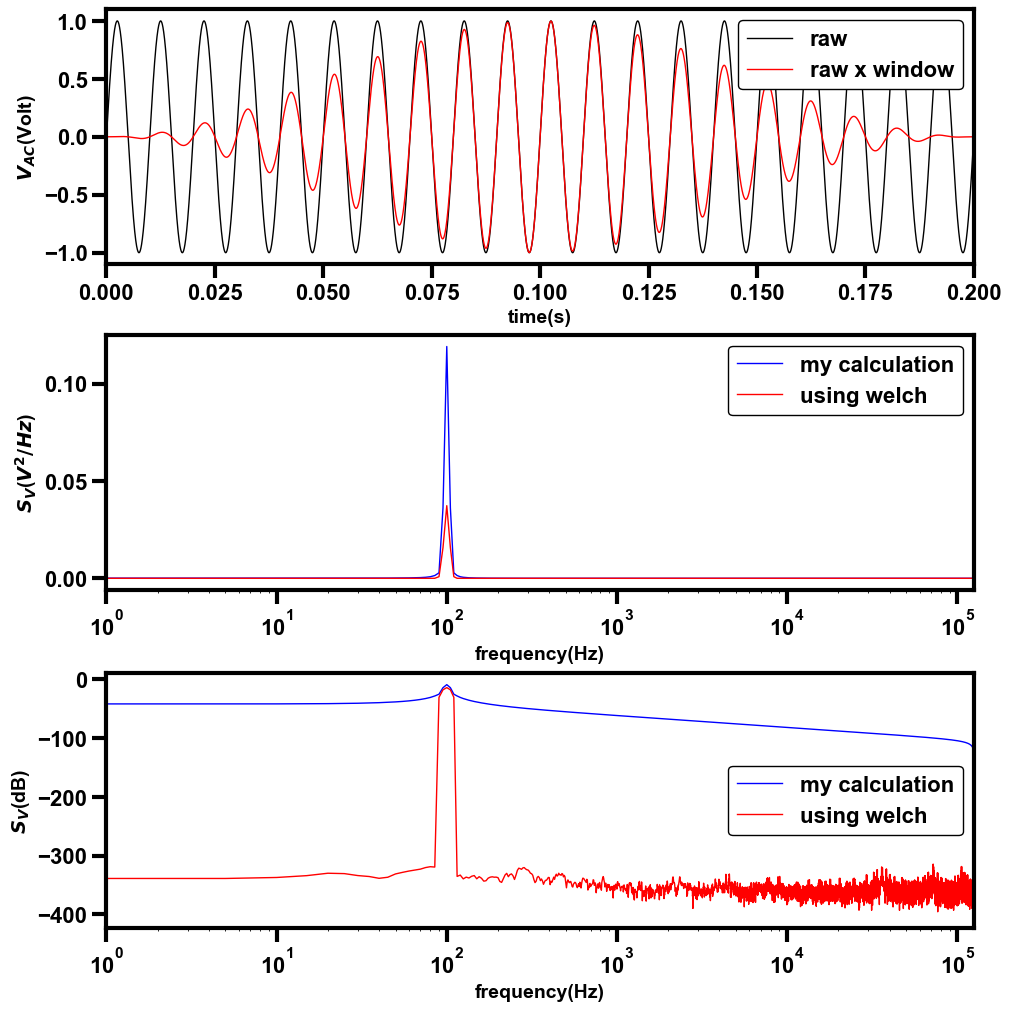

In [14]:
sampling_rate = 0.25e6 # Hz
sampling_time = 0.2 # seconds
N = int(sampling_rate*sampling_time) # number of samples
time = np.arange(0,sampling_time,1/sampling_rate)

V = np.sin(2*np.pi*100*time) # sine signal with frequency 100Hz

V = V - np.mean(V)

Vraw = V
V = V*hann(N+1) # smoothing using a hamming window

auto_corr = correlate(V,V, mode="same") # mode="same" returns the same length as the input i.e. lags start from 0 to (N-1)*dt
S = fft(auto_corr)
S = S[:S.size//2]
S = 2*S/N**2
freq = fftfreq(len(auto_corr), d=1/sampling_rate)
freq = freq[:freq.size//2]

fq, SS = welch(V, fs=sampling_rate, window='hamming', nperseg=N, noverlap=0, return_onesided=True, scaling='density', axis=-1)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (10,10), constrained_layout=True)
ax1.plot(time, Vraw, label="raw")
ax1.plot(time, V, label="raw x window")
ax1.set_xlim(time.min(),time.max())
ax1.set_xlabel('time(s)')
ax1.set_ylabel('$V_{AC}$(Volt)')

ax2.plot(freq, np.absolute(S), 'b-', markersize=3, label="my calculation")
ax2.plot(fq, np.absolute(SS), 'r-', markersize=3, label="using welch")
ax2.set_xlabel('frequency(Hz)')
ax2.set_ylabel('$S_V$($V^2/Hz$)')
ax2.set_xlim(1, freq.max())
ax2.set_xscale('log')
# ax2.set_yscale('log')


ax3.plot(freq, 10*np.log10(np.absolute(S)), 'b-', markersize=3, label="my calculation")
ax3.plot(fq,10*np.log10(SS),'r-', label="using welch")
ax3.set_xlabel('frequency(Hz)')
ax3.set_ylabel('$S_V$(dB)')
ax3.set_xlim(1, freq.max())
ax3.set_xscale('log')

ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

# Trying with actual data from scope

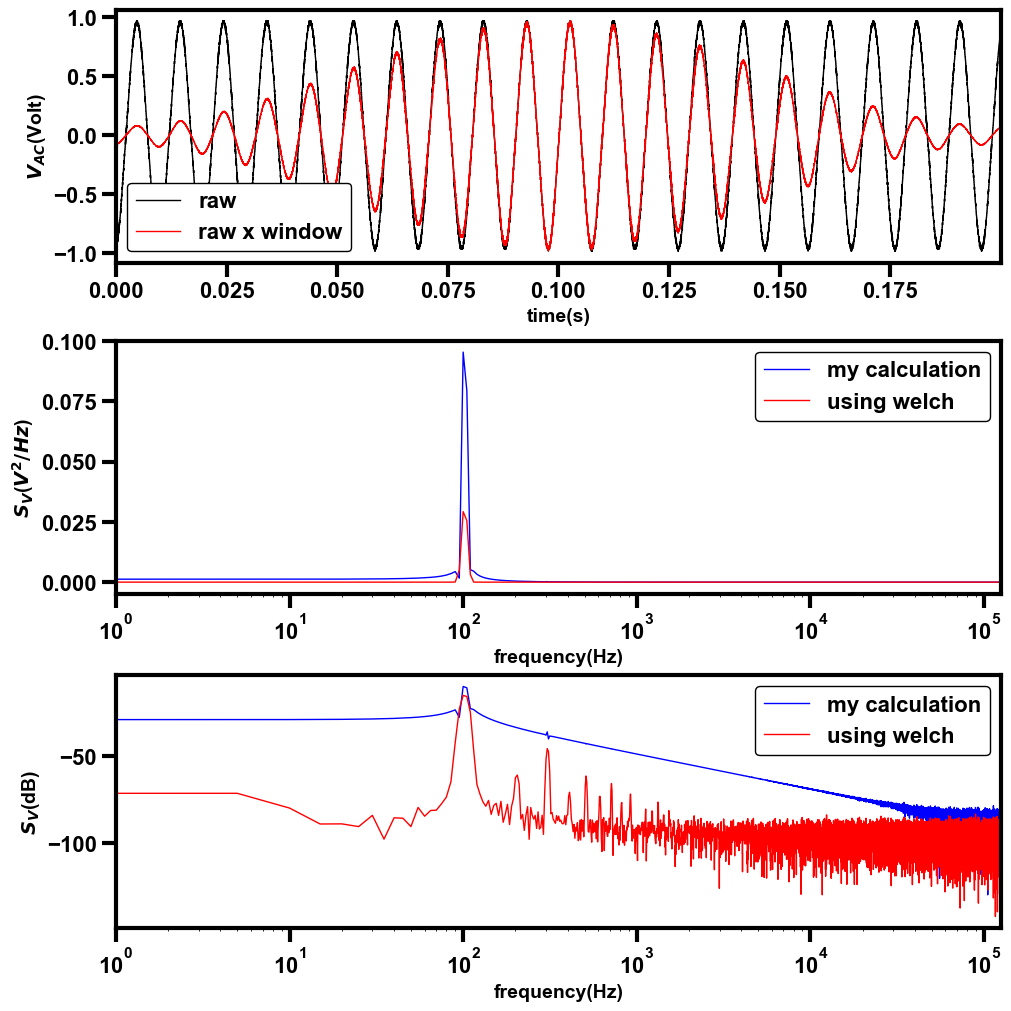

In [15]:
fp="./data/scope_1.csv"
df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"])
df.head()

sampling_time = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
sampling_rate = N/sampling_time # Hz
time = df["time"].to_numpy() - df["time"].min()

V = df["voltage"].to_numpy() # sine signal with frequency 500Hz

V = V - np.mean(V)

Vraw = V
V = V*hamming(N) # smoothing using a hamming window

auto_corr = correlate(V,V, mode="same") # mode="same" returns the same length as the input i.e. lags start from 0 to (N-1)*dt
S = fft(auto_corr)
S = S[:S.size//2]
S = 2*S/N**2
freq = fftfreq(len(auto_corr), d=1/sampling_rate)
freq = freq[:freq.size//2]

fq, SS = welch(V, fs=sampling_rate, window='hamming', nperseg=N, noverlap=0, return_onesided=True, scaling='density', axis=-1)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (10,10), constrained_layout=True)
ax1.plot(time, Vraw, label="raw")
ax1.plot(time, V, label="raw x window")
ax1.set_xlim(time.min(),time.max())
ax1.set_xlabel('time(s)')
ax1.set_ylabel('$V_{AC}$(Volt)')

ax2.plot(freq, np.absolute(S), 'b-', markersize=3, label="my calculation")
ax2.plot(fq, np.absolute(SS), 'r-', markersize=3, label="using welch")
ax2.set_xlabel('frequency(Hz)')
ax2.set_ylabel('$S_V$($V^2/Hz$)')
ax2.set_xlim(1, freq.max())
ax2.set_xscale('log')
# ax2.set_yscale('log')


ax3.plot(freq, 10*np.log10(np.absolute(S)), 'b-', markersize=3, label="my calculation")
ax3.plot(fq,10*np.log10(SS),'r-', label="using welch")
ax3.set_xlabel('frequency(Hz)')
ax3.set_ylabel('$S_V$(dB)')
ax3.set_xlim(1, freq.max())
ax3.set_xscale('log')

ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

# 10 kOhm resistor data

1.5 Volt battery with 10 M Ohm resistor in series gives 1.5 uA of current.

This current flows through a 10 kOhm resistor to give a voltage drop of V = 1.5 uA x 10 kOhm = 1.5 mV

The thermal noise should be equal to $S_V(f)$ = 4kTR = 104 meV x 10 kOhm = 1.664e-16 V^2/Hz


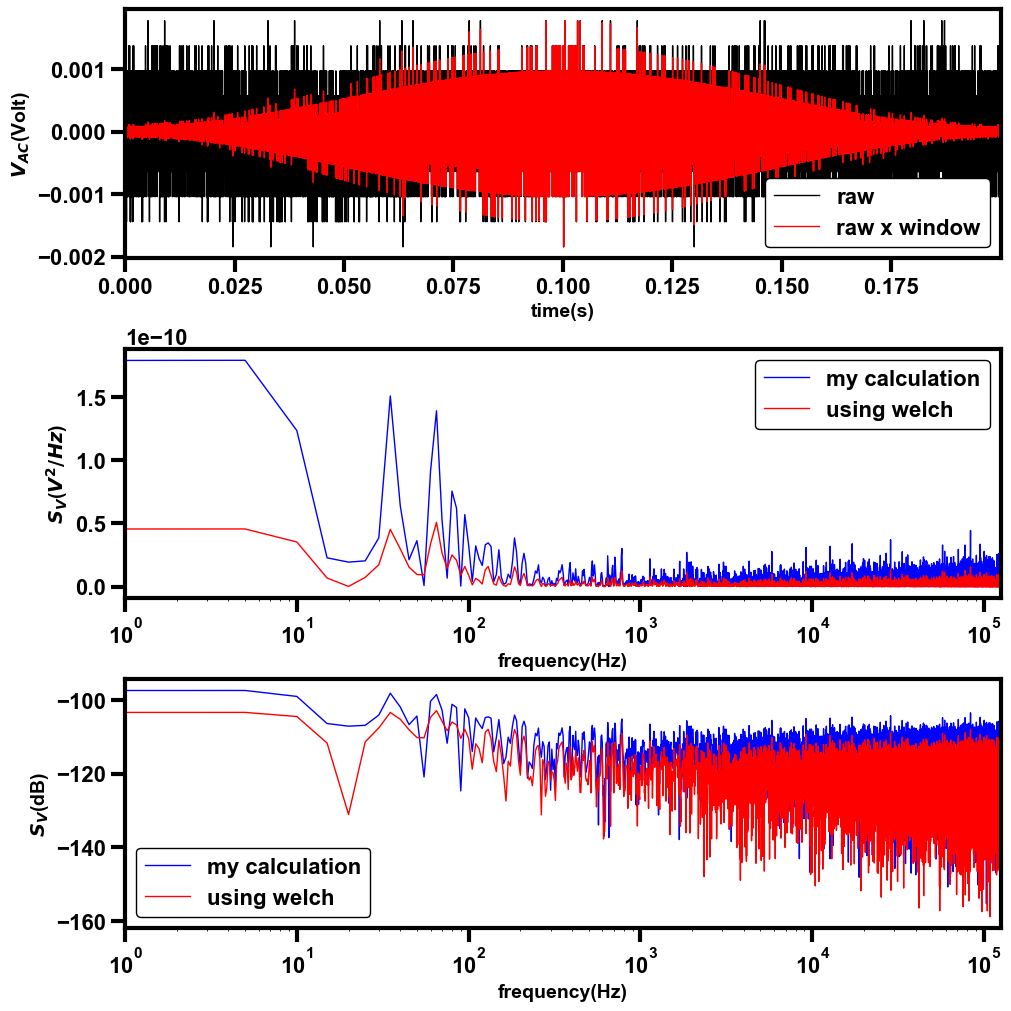

In [16]:
fp="./data/scope_2.csv"
df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"])
df.head()

sampling_time = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
sampling_rate = N/sampling_time # Hz
time = df["time"].to_numpy() - df["time"].min()

V = df["voltage"].to_numpy() # sine signal with frequency 500Hz

V = V - np.mean(V)

Vraw = V
V = V*hamming(N) # smoothing using a hamming window

auto_corr = correlate(V,V, mode="same") # mode="same" returns the same length as the input i.e. lags start from 0 to (N-1)*dt
S = fft(auto_corr)
S = S[:S.size//2]
S = 2*S/N**2
freq = fftfreq(len(auto_corr), d=1/sampling_rate)
freq = freq[:freq.size//2]

fq, SS = welch(V, fs=sampling_rate, window='hamming', nperseg=N, noverlap=0, return_onesided=True, scaling='density', axis=-1)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (10,10), constrained_layout=True)
ax1.plot(time, Vraw, label="raw")
ax1.plot(time, V, label="raw x window")
ax1.set_xlim(time.min(),time.max())
ax1.set_xlabel('time(s)')
ax1.set_ylabel('$V_{AC}$(Volt)')

ax2.plot(freq, np.absolute(S), 'b-', markersize=3, label="my calculation")
ax2.plot(fq, np.absolute(SS), 'r-', markersize=3, label="using welch")
ax2.set_xlabel('frequency(Hz)')
ax2.set_ylabel('$S_V$($V^2/Hz$)')
ax2.set_xlim(1, freq.max())
ax2.set_xscale('log')
# ax2.set_yscale('log')


ax3.plot(freq, 10*np.log10(np.absolute(S)), 'b-', markersize=3, label="my calculation")
ax3.plot(fq,10*np.log10(SS),'r-', label="using welch")
ax3.set_xlabel('frequency(Hz)')
ax3.set_ylabel('$S_V$(dB)')
ax3.set_xlim(1, freq.max())
ax3.set_xscale('log')

ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

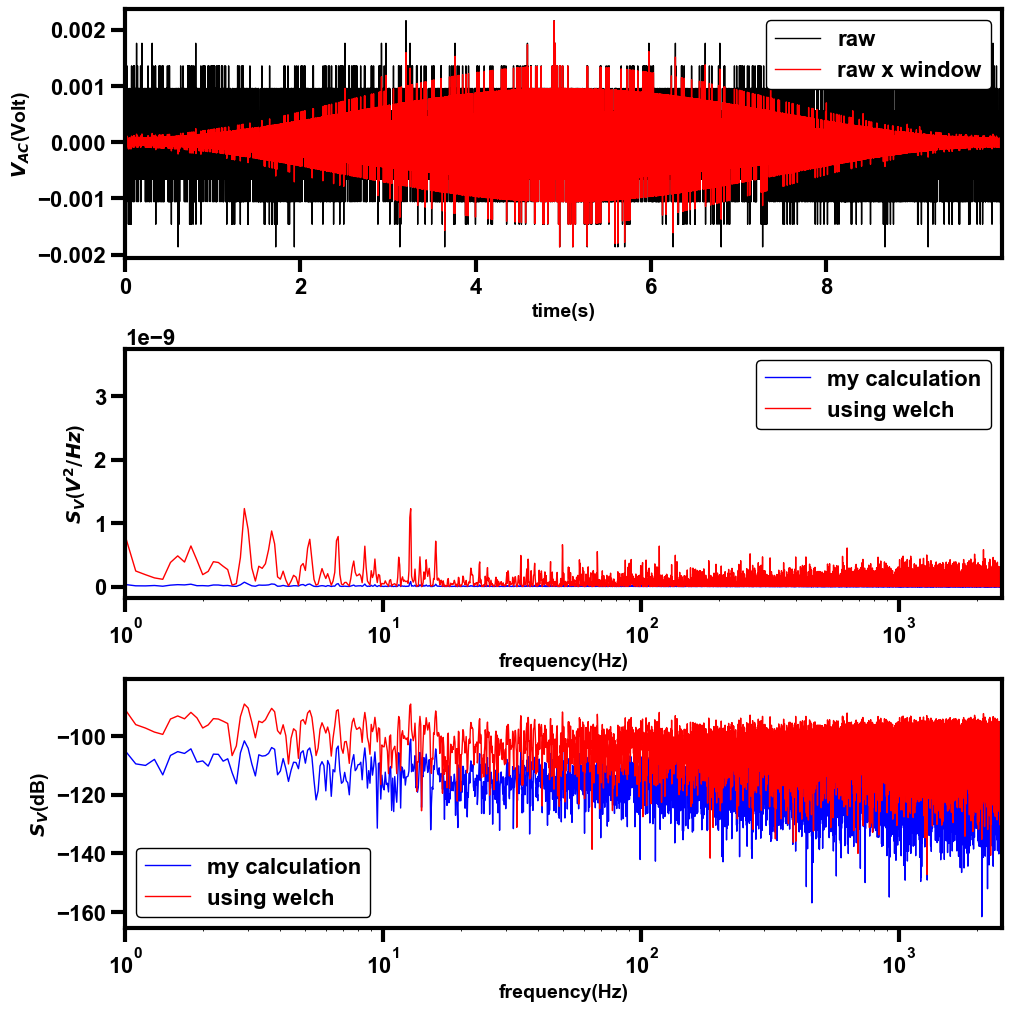

In [17]:
fp="./data/scope_4.csv"
df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"])
df.head()

sampling_time = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
sampling_rate = N/sampling_time # Hz
time = df["time"].to_numpy() - df["time"].min()

V = df["voltage"].to_numpy() # sine signal with frequency 500Hz

V = V - np.mean(V)

Vraw = V
V = V*hamming(N) # smoothing using a hamming window

auto_corr = correlate(V,V, mode="same") # mode="same" returns the same length as the input i.e. lags start from 0 to (N-1)*dt
S = fft(auto_corr)
S = S[:S.size//2]
S = 2*S/N**2
freq = fftfreq(len(auto_corr), d=1/sampling_rate)
freq = freq[:freq.size//2]

fq, SS = welch(V, fs=sampling_rate, window='hamming', nperseg=N, noverlap=0, return_onesided=True, scaling='density', axis=-1)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (10,10), constrained_layout=True)
ax1.plot(time, Vraw, label="raw")
ax1.plot(time, V, label="raw x window")
ax1.set_xlim(time.min(),time.max())
ax1.set_xlabel('time(s)')
ax1.set_ylabel('$V_{AC}$(Volt)')

ax2.plot(freq, np.absolute(S), 'b-', markersize=3, label="my calculation")
ax2.plot(fq, np.absolute(SS), 'r-', markersize=3, label="using welch")
ax2.set_xlabel('frequency(Hz)')
ax2.set_ylabel('$S_V$($V^2/Hz$)')
ax2.set_xlim(1, freq.max())
ax2.set_xscale('log')
# ax2.set_yscale('log')


ax3.plot(freq, 10*np.log10(np.absolute(S)), 'b-', markersize=3, label="my calculation")
ax3.plot(fq,10*np.log10(SS),'r-', label="using welch")
ax3.set_xlabel('frequency(Hz)')
ax3.set_ylabel('$S_V$(dB)')
ax3.set_xlim(1, freq.max())
ax3.set_xscale('log')

ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

## 10 k Ohm background

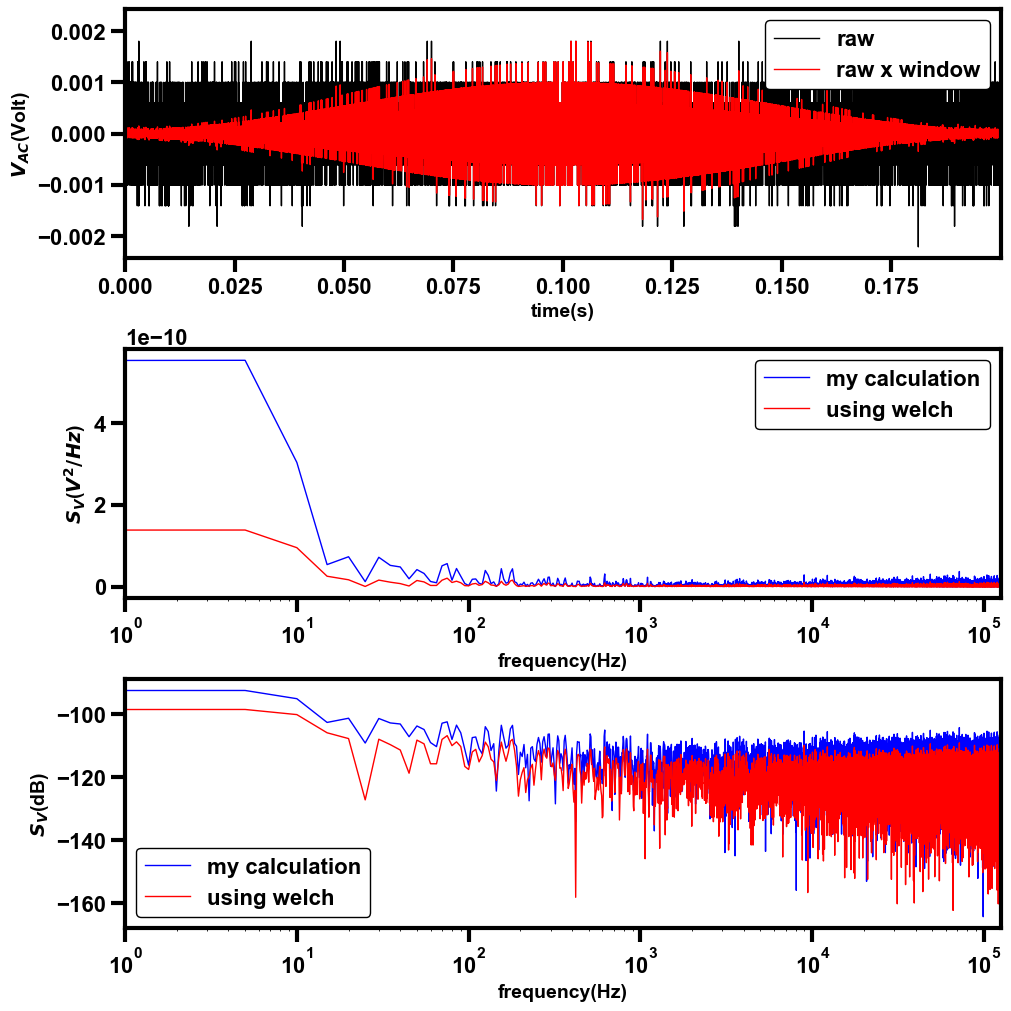

In [18]:
fp="./data/scope_3.csv"
df=pd.read_csv(fp,header=0,sep=",",skiprows=1, names=["time", "voltage"])
df.head()

sampling_time = df["time"].max()-df["time"].min() # seconds
N = df.shape[0]
sampling_rate = N/sampling_time # Hz
time = df["time"].to_numpy() - df["time"].min()

V = df["voltage"].to_numpy() # sine signal with frequency 500Hz

V = V - np.mean(V)

Vraw = V
V = V*hamming(N) # smoothing using a hamming window

auto_corr = correlate(V,V, mode="same") # mode="same" returns the same length as the input i.e. lags start from 0 to (N-1)*dt
S = fft(auto_corr)
S = S[:S.size//2]
S = 2*S/N**2
freq = fftfreq(len(auto_corr), d=1/sampling_rate)
freq = freq[:freq.size//2]

fq, SS = welch(V, fs=sampling_rate, window='hamming', nperseg=N, noverlap=0, return_onesided=True, scaling='density', axis=-1)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = (10,10), constrained_layout=True)
ax1.plot(time, Vraw, label="raw")
ax1.plot(time, V, label="raw x window")
ax1.set_xlim(time.min(),time.max())
ax1.set_xlabel('time(s)')
ax1.set_ylabel('$V_{AC}$(Volt)')

ax2.plot(freq, np.absolute(S), 'b-', markersize=3, label="my calculation")
ax2.plot(fq, np.absolute(SS), 'r-', markersize=3, label="using welch")
ax2.set_xlabel('frequency(Hz)')
ax2.set_ylabel('$S_V$($V^2/Hz$)')
ax2.set_xlim(1, freq.max())
ax2.set_xscale('log')
# ax2.set_yscale('log')


ax3.plot(freq, 10*np.log10(np.absolute(S)), 'b-', markersize=3, label="my calculation")
ax3.plot(fq,10*np.log10(SS),'r-', label="using welch")
ax3.set_xlabel('frequency(Hz)')
ax3.set_ylabel('$S_V$(dB)')
ax3.set_xlim(1, freq.max())
ax3.set_xscale('log')

ax1.legend()
ax2.legend()
ax3.legend()
plt.show()
